# Los Angeles Homelessness Clusters

A map of the most prevelent race/ethnicity of homelessness, by tract. 


The Los Angeles County Economic Round Table maintains a [data collection for the Los Angeles Point In Time homelessness counts](https://economicrt.org/publication/los-angeles-county-homeless-count-data-library/), as well as data sets for the associated in person surveys. It's a really remarkable collection, with information both about the loactions of the homeless, as well as information about their demographics and health issues. The [San Diego Regional Data Library](http://sandiegodata.org) has produced an [analysis dataset of the survey data](https://data.sandiegodata.org/dataset/economicrt-org-homeless_survey-2011e2017) with a few re-coded variables, including Census geoids, that make analysis easier. 

For this example, we will link the survey responses to Census tracts and create a chroropleth map colored by the race/ethnicity with the most people of that race/ethnicity surveyed in the tract. Note that this measure is only related to the most common race/ethnicity of the homeless of that tract if the surveyors interviewed people randomly. It's possible that the interviews focused on a particular demographic, which would skew these results. 


In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
sns.set(color_codes=True)


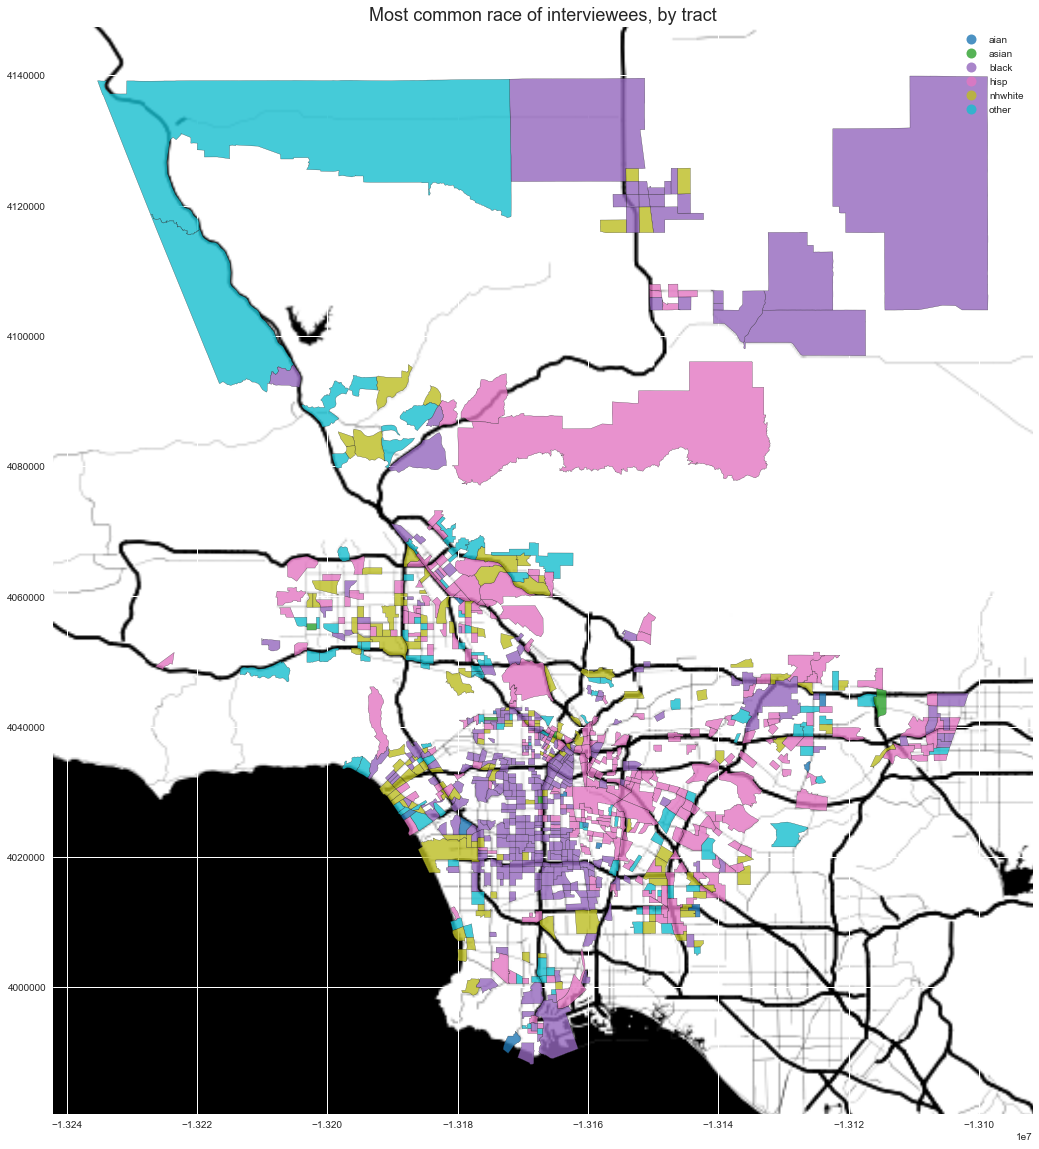

In [39]:
pkg = mp.open_package('http://library.metatab.org/economicrt.org-homeless_survey-2011e2017.csv')

hs = pkg.resource('homeless_survey').dataframe()

# Get per-race/eth tract estimates from the Census
raceeth = rg.dataframe('census://2017/5/CA/tract/B03002')

cols = {
    'b03002_001':'total',
    'b03002_003':'nhwhite',
    'b03002_004':'black',
    'b03002_012':'hispanic',
    'b03002_006':'asian',
}

# Simplify the raceeth table to just the column we need
t = raceeth[list(cols.keys())].rename(columns=cols)
t['other'] = t.total - t.nhwhite - t.black - t.asian - t.hispanic
raceeth = t[list(cols.values())+['other']]

hs['count'] =  1

max_re  =hs[hs.geoid.notnull()].groupby(['geoid','raceeth']).sum()['count'].to_frame().unstack()
max_re ['max_re'] = max_re .idxmax(1).apply(lambda v: v[1])

max_re.columns = max_re.columns.droplevel()
max_re.columns = list(max_re.columns)[:-1] + ['max_re']

# Link the data to a geoframe of the tracts. 
tracts = rg.geoframe('census://2017/5/CA/tract')
max_re = tracts.set_index('geoid')[['geometry']].join(max_re,how='right').dropna(subset=['geometry'])

# Add a basemap, as per the Geopandas documentation. 
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# The web tiles are in epsg=3857, so we have to transform our map
ax = max_re.to_crs(epsg=3857).plot(column='max_re', figsize=(20, 20), alpha=0.8, 
                                  edgecolor='k', cmap='tab10', legend=True)
add_basemap(ax, zoom=9, url=ctx.sources.ST_TONER_BACKGROUND )
ax.set_title('Most common race of interviewees, by tract', fontsize=18);


Although it is possible that the interviewing was not a random sample, there is evidence that it probably is: the primary cluster of black-predominant responses corresponds with the tracts that have a high portion of Black population.  The following map shows the protion of the total tract population that is black, for tracts with more than 10% of the population being black. 

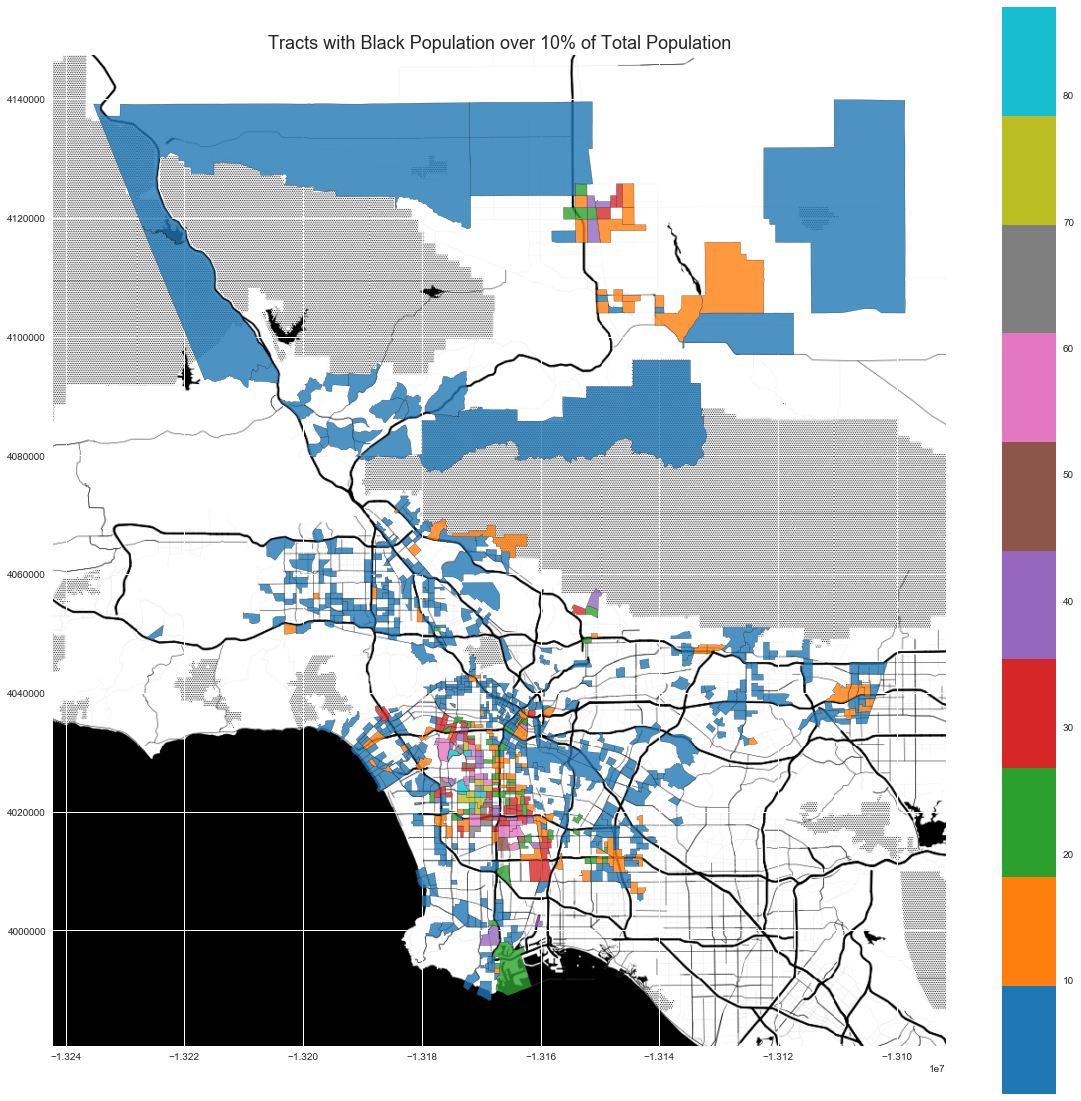

In [40]:
re_tr = max_re[['geometry','max_re']].join(raceeth)
re_tr['black_rate'] = (re_tr.black / re_tr.total * 100 ).round(0)
re_tr.dropna(inplace=True)

re_tr = re_tr[re_tr.black_rate > .10]

# The web tiles are in epsg=3857, so we have to transform our map
ax = re_tr.to_crs(epsg=3857).plot(column='black_rate', figsize=(20, 20), alpha=0.8, 
                                  edgecolor='k', cmap='tab10', legend=True)
add_basemap(ax, zoom=10, url=ctx.sources.ST_TONER_BACKGROUND )
ax.set_title('Tracts with Black Population over 10% of Total Population', fontsize=18);